In [1]:
from python_dict_wrapper import wrap
import sys
sys.path.append('../')
import paths
sys.path.append(paths.CPC_DPC)
sys.path.append(paths.CPC_BACKBONE)

/home/pmin/anaconda3/envs/yh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MouseNet does not exist
Using DPC-RNN model
final feature map has size 16x16


In [2]:
import torch

/home/pmin/anaconda3/envs/yh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using DPC-RNN model
final feature map has size 16x16


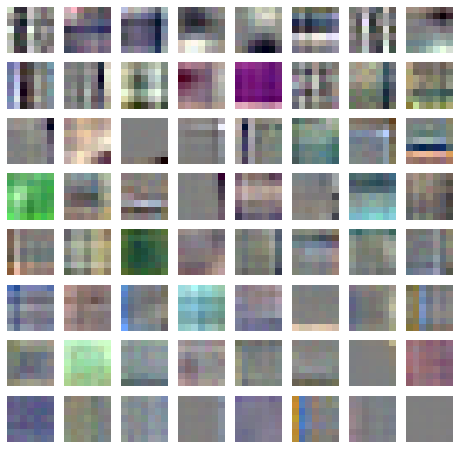

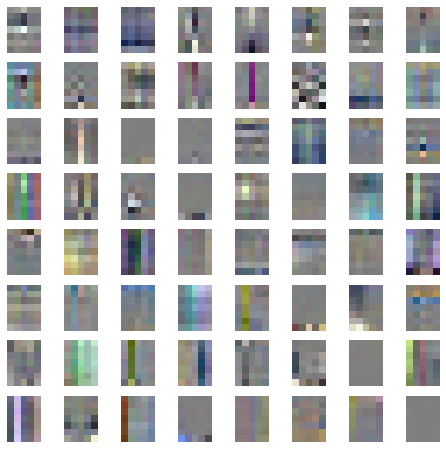

Using DPC-RNN model
final feature map has size 2x2


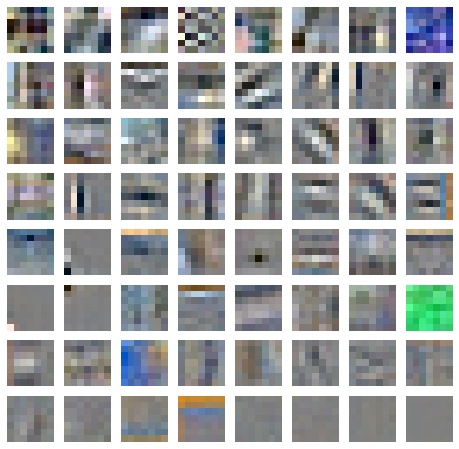

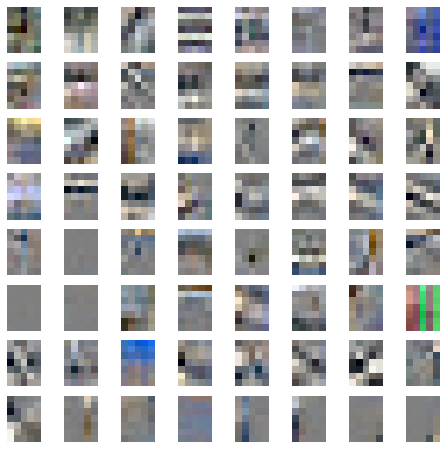

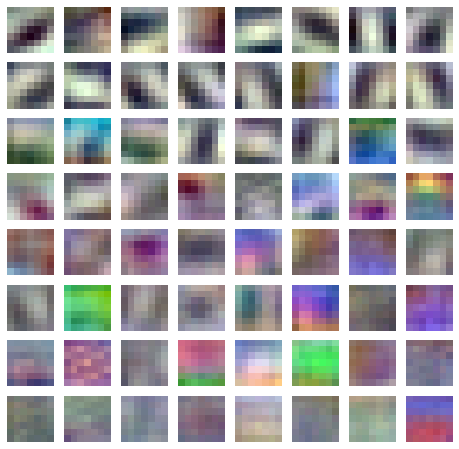

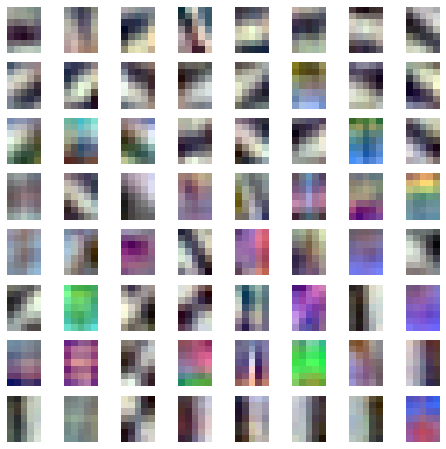

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

def find_dominant_orientation(W):
    Wf = abs(np.fft.fft2(W))
    orient_sel = 1 - Wf[0, 0] / Wf.sum()
    Wf[0, 0] = 0
    Wf = np.fft.fftshift(Wf)
    dt = W.shape[0] // 2
    xi, yi = np.meshgrid(np.arange(-dt, dt+1), np.arange(-dt, dt+1))
    
    # Check whether we should split this horizontally or vertically
    if Wf[xi == 0].sum() > Wf[yi == 0].sum():
        # Use a top-down split        
        xi_ = xi * (xi >= 0)
        yi_ = yi * (xi >= 0)
        x0 = (xi_ * Wf).sum() / ((xi >= 0) * Wf).sum()
        y0 = (yi_ * Wf).sum() / ((xi >= 0) * Wf).sum()
    else:
        xi_ = xi * (yi >= 0)
        yi_ = yi * (yi >= 0)
        x0 = (xi_ * Wf).sum() / ((yi >= 0) * Wf).sum()
        y0 = (yi_ * Wf).sum() / ((yi >= 0) * Wf).sum()
    return np.arctan2(y0, x0), orient_sel

def get_spatial_slice(W, theta):
    dx = W.shape[0] // 2
    dt = W.shape[2] // 2
    xi, yi, zi = np.meshgrid(np.arange(W.shape[0]), 
                             np.arange(W.shape[1]),
                             np.arange(W.shape[2]))
    
    xi_, zi_ = np.meshgrid(np.arange(W.shape[0]), 
                         np.arange(W.shape[2]))
    Ws = []
    for i in range(W.shape[3]):
        interp = scipy.interpolate.LinearNDInterpolator(np.array([xi.ravel(), 
                                                                  yi.ravel(), 
                                                                  zi.ravel()]).T, W[:, :, :, i].ravel())
        probe = np.array([dx + (xi_ - dx) * np.cos(theta),
                 dx + (xi_ - dx) * np.sin(theta),
                 zi_]).T
        Ws.append(interp(probe))
        
    return np.stack(Ws, axis=2)

def plot_static_shot(W):
    #assert W.shape[0] == 64
    W = W / abs(W).max(axis=4).max(axis=3).max(axis=2).max(axis=1).reshape(-1, 1, 1, 1, 1) / 2 + .5
    t = W.shape[2] // 2
    
    best_thetas = []
    orient_sels = []
    for i in range(W.shape[0]):
        theta, orient_sel = find_dominant_orientation(W[i, :, t, :, :].transpose(1, 2, 0).sum(2))
        best_thetas.append(theta)
        orient_sels.append(orient_sel)
        
    best_thetas = np.array(best_thetas)
    orient_sels = np.array(orient_sels)
    
    sort_idx = np.argsort(orient_sels)[::-1]
    best_thetas = best_thetas[sort_idx]
    orient_sels = orient_sels[sort_idx]
    W = W[sort_idx, :, :, :, :]
    
    plt.figure(figsize=(8, 8))
    for i in range(W.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(W[i, :, t, :, :].transpose(1, 2, 0))
        theta = best_thetas[i]
        #plt.plot([3 + 3 * np.sin(theta), 3 - 3 * np.sin(theta)], [3 + 3 * np.cos(theta), 3 - 3 * np.cos(theta)], 'r-')
        plt.axis(False)
    #plt.suptitle(f'xy filters, sliced at t = {t}')
    plt.show()
        
    dt = W.shape[-1] // 2
    xi, yi = np.meshgrid(np.arange(-dt, dt+1), np.arange(-dt, dt+1))
    
    plt.figure(figsize=(8, 8))
    for i in range(W.shape[0]):
        W_ = W[i, :, :, :, :].transpose((3, 2, 1, 0))
        plt.subplot(8, 8, i + 1)
        theta = best_thetas[i]
        W_ = get_spatial_slice(W_, theta)
        plt.imshow(W_)
        plt.axis(False)
    plt.show()

from models import get_feature_model
args = wrap({'features': 'cpc_02',
             'ckpt_root': paths.CHECKPOINTS,
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

model, _, _ = get_feature_model(args)
        
plot_static_shot(model.s1.conv1.weight.detach().cpu().numpy())

args = wrap({'features': 'cpc_01',
             'ckpt_root': paths.CHECKPOINTS,
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})


model, _, _ = get_feature_model(args)
        
plot_static_shot(model.s1.conv1.weight.detach().cpu().numpy())

args = wrap({'features': 'airsim_04',
             'ckpt_root': paths.CHECKPOINTS,
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})


model, _, _ = get_feature_model(args)
        
plot_static_shot(model.s1.conv1.weight.detach().cpu().numpy())

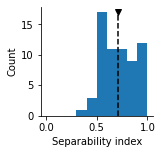

In [3]:
data = model.s1.conv1.weight.detach().cpu().numpy()
F = data.mean(axis=1).reshape((64, 5, 7*7))
sepindexes = []

for i in range(F.shape[0]):
    U, S, V = np.linalg.svd(F[i, :, :])
    sepindex = S[0] ** 2 / (S ** 2).sum() 
    sepindexes.append(sepindex)

    
plt.figure(figsize=(2,2))
plt.hist(sepindexes, np.arange(11)/10)
plt.xlabel('Separability index')
plt.ylabel('Count')

plt.plot([.71, .71], [0, 17], 'k--')
plt.plot([.71], [17], 'kv')

import seaborn as sns
sns.despine()